# Linear Regression with stratified sampling

Try to apply a linear regression model to the merged otu table

In [1]:
import os
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from dotenv import load_dotenv
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skbio.stats.composition import multiplicative_replacement, clr

from src import project_directory
from src.database import get_session, Sample, Dataset

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)
_ = load_dotenv()

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['KR9NH_sample_100' 'KR9NH_sample_10' 'KR9NH_sample_11' 'KR9NH_sample_12'
 'KR9NH_sample_13' 'KR9NH_sample_14' 'KR9NH_sample_15' 'KR9NH_sample_16'
 'KR9NH_sample_17' 'KR9NH_sample_18']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}
sample2dataset = {sample.sample_id: sample.dataset_id for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)
metadata['dataset'] = metadata.index.map(sample2dataset)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[0])

defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7f245be29a80>, {'tissue': 'gut', 'dataset': 54})


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)
otu_df['dataset'] = otu_df.index.map(sample2dataset)

Inspect the created dataframe:

In [8]:
# collect unique tissue-dataset pairs
tissue_dataset_table = otu_df[['tissue', 'dataset']].drop_duplicates().sort_values(['tissue', 'dataset'])
tissue_dataset_table.reset_index(drop=True)


,tissue,dataset
0,feces,47
1,gut,54
2,hindgut,3
3,hindgut,13
4,milk,15
5,milk,16
6,milk,53
7,rumen,2
8,rumen,14
9,rumen,48


Simply count how many samples per tissue we have:

In [9]:
otu_df["tissue"].value_counts()

tissue
milk       535
rumen      146
hindgut    141
gut        100
feces       29
Name: count, dtype: int64

Transform tables:

In [10]:
groups = otu_df["dataset"]
X = otu_df.drop(columns=["tissue", "dataset"])
y = otu_df["tissue"]

So the point is that we have 8 datasets for 4 tissues: if I simply divide the dataset using `train_test_split, I will have in test set samples from the same dataset of the training set: this could be a data leakage. So let's try to split the dataset in
order to not have samples in the test set from the same dataset of the training set:

In [11]:
gss = GroupShuffleSplit(test_size=0.5, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

A test of groups:

In [12]:
train_groups = []
test_groups = []

for group in set(groups.iloc[train_idx]):
    group = int(group)
    dataset = session.query(Dataset).filter(Dataset.id == group).one()
    train_groups.append((group, dataset.tissue, dataset.project))
print("train groups:", train_groups)

for group in set(groups.iloc[test_idx]):
    group = int(group)
    dataset = session.query(Dataset).filter(Dataset.id == group).one()
    test_groups.append((group, dataset.tissue, dataset.project))
print("test groups:", test_groups)


train groups: [(13, 'hindgut', 'RABOLA'), (14, 'rumen', 'RABOLA'), (15, 'milk', 'RABOLA'), (47, 'feces', 'Grant-201801062101'), (54, 'gut', 'LEGUPLUS')]
test groups: [(2, 'rumen', 'FARM-INN'), (3, 'hindgut', 'FARM-INN'), (48, 'rumen', 'Grant-201801062101'), (16, 'milk', 'RABOLA'), (53, 'milk', 'MORGOAT')]


Ok, now create train and test set relyin on indexes:

In [13]:
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

Convert to relative abundances:

In [14]:
X_train_relative = X_train.div(X_train.sum(axis=1), axis=0)
X_test_relative = X_test.div(X_test.sum(axis=1), axis=0)

# check that the sum of each sample is approximately 1
print(f"Sum train (should be ~1.0): {X_train_relative.sum(axis=1).head()}")
print(f"Sum test (should be ~1.0): {X_test_relative.sum(axis=1).head()}")

Sum train (should be ~1.0): KR9NH_sample_100    1.0
KR9NH_sample_10     1.0
KR9NH_sample_11     1.0
KR9NH_sample_12     1.0
KR9NH_sample_13     1.0
dtype: float64
Sum test (should be ~1.0): H_10_S10_L001    1.0
H_11_S11_L001    1.0
H_12_S12_L001    1.0
H_13_S13_L001    1.0
H_14_S14_L001    1.0
dtype: float64


Replace zeros and apply clr transformation:

In [15]:
X_train_comp = multiplicative_replacement(X_train_relative.values)
X_test_comp = multiplicative_replacement(X_test_relative.values)

X_train_clr = clr(X_train_comp)
X_test_clr = clr(X_test_comp)

/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/skbio/util/_warning.py:42: DeprecationWarning: `multiplicative_replacement` was renamed to `multi_replace` in 0.6.0. The old name is kept as an alias but is deprecated.
  warn(message, warning)


## Creating a model

In [16]:
model = LogisticRegression(solver="liblinear", max_iter=int(os.getenv("MAX_ITER", 1000)))

In [17]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [18]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=int(os.getenv("MAX_CPUS", -1)), verbose=1, cv=5)

In [19]:
grid_search.fit(X_train_clr, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=215900) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=215900) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [20]:
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [21]:
y_pred = grid_search.predict(X_test_clr)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.6572052401746725
Classification Report:
              precision    recall  f1-score   support

       feces       0.00      0.00      0.00         0
         gut       0.00      0.00      0.00         0
     hindgut       1.00      0.98      0.99        56
        milk       0.99      0.51      0.67       316
       rumen       1.00      1.00      1.00        86

    accuracy                           0.66       458
   macro avg       0.60      0.50      0.53       458
weighted avg       1.00      0.66      0.77       458



/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_divisi

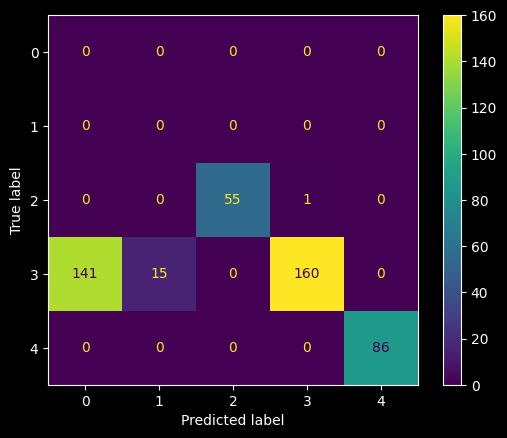

In [23]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

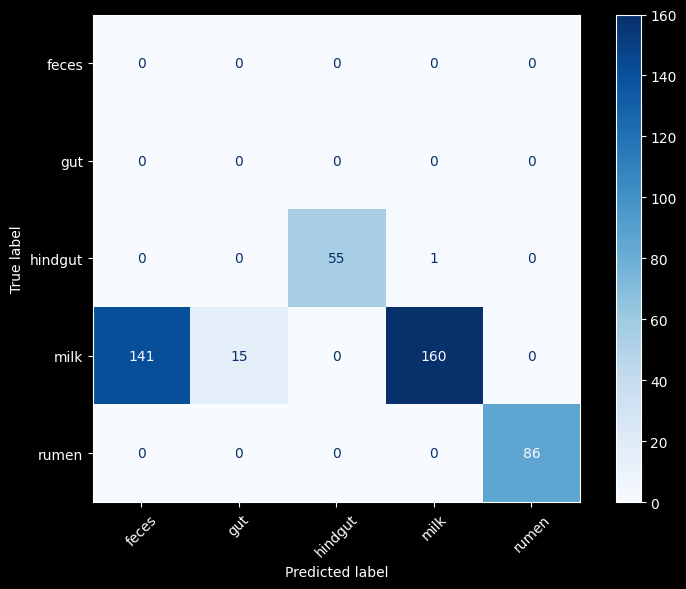

In [24]:
# fallback: unione ordinata di y_true e y_pred per garantire tutte le etichette
class_names = np.unique(np.concatenate([y_test.astype(str), y_pred.astype(str)]))

# Ricomponi la confusion matrix usando le etichette testuali e visualizza
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", values_format='d')
plt.tight_layout()
plt.show()

Get the best model and save it to a file:

In [25]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [26]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
26639d9f66c6c2106996b1c162605ff8,-0.029706,0.029706
3c097b9bdd9f25cb9d814d6ad2bbc325,-0.027066,0.027066
9337d5571c3f1350debea510d6bdd099,-0.019479,0.019479
d47976ef5d2df3a702c515c9b610a05b,-0.019159,0.019159
d68ce1ee602aa886d34ef344207522ab,-0.016981,0.016981
565b4f421328126f98e9f2aff31630f1,-0.015704,0.015704
9fd944b60ec63ff4c85b3da3ebd73b10,-0.015524,0.015524
b784d0c48f861b5580115402130a98cd,-0.015512,0.015512
c9eb1ec1b179d48c1962fe348404dabe,-0.015096,0.015096


try to load the taxononies from file

In [27]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
00014fe9293f8f515587a4c2a3586c1b,Bacteria,,,,,,,
00020edaea2d646fb6acffceb62720ec,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae YAB2003 group,,


In [28]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
26639d9f66c6c2106996b1c162605ff8,-0.029706,0.029706,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,smithii,
3c097b9bdd9f25cb9d814d6ad2bbc325,-0.027066,0.027066,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,,
9337d5571c3f1350debea510d6bdd099,-0.019479,0.019479,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanosphaera,stadtmanae,
d47976ef5d2df3a702c515c9b610a05b,-0.019159,0.019159,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,smithii,
d68ce1ee602aa886d34ef344207522ab,-0.016981,0.016981,Bacteria,Actinobacteriota,Actinobacteria,Pseudonocardiales,Pseudonocardiaceae,Prauserella,aidingensis,
